In [1]:
#packages
import json
import tqdm
import os
import numpy as np
import sys
import glob
import pandas as pd
import datetime as dt
import re
import math
from collections import defaultdict
import operator
import random #ranomization
from sklearn.utils import shuffle #dataframe
from collections import OrderedDict #to reproduce results
from collections import Counter

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
import config_exp2 as config
path_extracted_data = config.path_extracted_data
path_extracted_data

'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\ALLDATA_'

# download data

In [3]:
path_FocalBird = r'G:\VPHI\Welfare\2- Research Projects\Camille Montalcini\Origins.GS\FOCAL BIRDS\Focalbirds_09-10-2021_usedRandom.csv'
df = pd.read_csv(path_FocalBird, sep=';', parse_dates=['StartDate','EndDate','InitialStartDate'], dayfirst=True, 
                 encoding='latin')
df['HenID'] = df['HenID'].map(lambda x: 'hen_'+str(x))
df['PenID'] = df['PenID'].map(lambda x: 'pen'+str(x))
print(df.shape)
df.head(3)

(169, 18)


,HenID,SireID,RPenID,PenID,Rtreatment,LPLegring,legringID,FocalLegringName,commentSelection,weight-08-10-2021,BackpackID,TagID,commentPopulation,exception,InitialStartDate,StartDate,EndDate,ShouldBeExcluded
0,hen_1,15,Rpen12,pen10,Queue,red,1,red1,was slected as 46 by random on computer but n...,1122.0,NaN,5,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN
1,hen_2,63,Rpen13,pen10,NoQueue,red,17,red17,NaN,1343.8,NaN,16,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN
2,hen_3,78,Rpen13,pen10,NoQueue,red,15,red15,NaN,1252.7,NaN,19,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN


# Relocation 1

### Chose randomly pens where birds could go to

In [4]:
#exact list of penID that can be assigned in addition to the 7 birds coming from each other pens, 
#based on the number of birds that will be used from each pen (i.e. we want to keep same #observation from each pen)
#based on total number (i.e. pen 12 has 20 focal birs and one more in pen 4)
li_possiblepenid = 3*['pen3']
li_possiblepenid.extend(4*['pen4'])
li_possiblepenid.extend(3*['pen5'])
li_possiblepenid.extend(4*['pen8'])
li_possiblepenid.extend(3*['pen9'])
li_possiblepenid.extend(4*['pen10'])
li_possiblepenid.extend(4*['pen11'])
li_possiblepenid.extend(3*['pen12'])
#li_possiblepenid

#now for each pen choose create a random list of penids that can be attriuted to its birds
dico_pen_nbr = {'pen3':10, 'pen4':11, 'pen5':10, 'pen8':11, 'pen9':10, 'pen10':11, 'pen11':11, 'pen12':10} 
li_allpen = ['pen3','pen4','pen5','pen8','pen9','pen10','pen11','pen12']

dico_pen_lipenavailble = {}
for penid in li_allpen:
    #step 1: an animal can be assigned to any other pen besides his own pen
    li = [i for i in li_allpen if i!=penid]
    #step 2: then add randomly other penids until you have the good amount of hens
    random.seed(penid) #new random seed for each pen
    nbr_animals = dico_pen_nbr[penid]
    li_2exclude = [penid]
    while len(li)<nbr_animals:
        #chose randomly among all other pens
        n = random.choice([i for i in li_possiblepenid if i not in li_2exclude]) #exclude also the one already picked twice!
        li_2exclude.append(n)
        li.append(n)
        li_possiblepenid.remove(n) #remove one time the value "n"
        #small verification
        #print(len(li), len(li_possiblepenid))
    dico_pen_lipenavailble[penid] = li

dico_pen_lipenavailble

{'pen3': ['pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen4',
  'pen9',
  'pen11'],
 'pen4': ['pen3',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen11',
  'pen10',
  'pen12',
  'pen8'],
 'pen5': ['pen3',
  'pen4',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen3',
  'pen10',
  'pen9'],
 'pen8': ['pen3',
  'pen4',
  'pen5',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen4',
  'pen10',
  'pen3',
  'pen12'],
 'pen9': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen10',
  'pen11',
  'pen12',
  'pen11',
  'pen8',
  'pen4'],
 'pen10': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen11',
  'pen12',
  'pen11',
  'pen12',
  'pen8',
  'pen5'],
 'pen11': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen12',
  'pen10',
  'pen3',
  'pen5',
  'pen9'],
 'pen12': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen8',
  'pen5',
  'pen4']}

### Attribute half of the birds in a pen a random pen among the possible and remaining penIDs

In [5]:
dico_pen_hen_r1 = {}
for penid, df_ in df.groupby(['PenID']):
    random.seed(int(penid.split('en')[-1])+100) 
    li_heninpen = df_['HenID'].tolist()
    random.shuffle(li_heninpen) #shuffle list randomly to attribute random pen
    li_penavailable = dico_pen_lipenavailble[penid]
    dico_pen_hen_r1[penid] = dict(zip(li_heninpen[0:len(li_penavailable)], li_penavailable))
dico_pen_hen_r1

{'pen10': {'hen_3': 'pen3',
  'hen_21': 'pen4',
  'hen_4': 'pen5',
  'hen_5': 'pen8',
  'hen_10': 'pen9',
  'hen_1': 'pen11',
  'hen_19': 'pen12',
  'hen_6': 'pen11',
  'hen_15': 'pen12',
  'hen_7': 'pen8',
  'hen_18': 'pen5'},
 'pen11': {'hen_22': 'pen3',
  'hen_40': 'pen4',
  'hen_36': 'pen5',
  'hen_26': 'pen8',
  'hen_29': 'pen9',
  'hen_27': 'pen10',
  'hen_23': 'pen12',
  'hen_33': 'pen10',
  'hen_30': 'pen3',
  'hen_39': 'pen5',
  'hen_25': 'pen9'},
 'pen12': {'hen_60': 'pen3',
  'hen_59': 'pen4',
  'hen_54': 'pen5',
  'hen_49': 'pen8',
  'hen_44': 'pen9',
  'hen_47': 'pen10',
  'hen_62': 'pen11',
  'hen_43': 'pen8',
  'hen_50': 'pen5',
  'hen_51': 'pen4'},
 'pen3': {'hen_79': 'pen4',
  'hen_71': 'pen5',
  'hen_82': 'pen8',
  'hen_72': 'pen9',
  'hen_76': 'pen10',
  'hen_63': 'pen11',
  'hen_67': 'pen12',
  'hen_80': 'pen4',
  'hen_81': 'pen9',
  'hen_74': 'pen11'},
 'pen4': {'hen_105': 'pen3',
  'hen_87': 'pen5',
  'hen_100': 'pen8',
  'hen_95': 'pen9',
  'hen_93': 'pen10',
  '

In [6]:
#attribute to each bird their relocated pens
df['R1'] = df.apply(lambda x: dico_pen_hen_r1[x['PenID']].get(x['HenID'],x['PenID']), axis=1)
#flag brds that are now relocated-birds
df['RelocationBird'] = df.apply(lambda x: x['PenID']!=x['R1'], axis=1)
df[['PenID','HenID','R1','RelocationBird']].head(10)

,PenID,HenID,R1,RelocationBird
0,pen10,hen_1,pen11,True
1,pen10,hen_2,pen10,False
2,pen10,hen_3,pen3,True
3,pen10,hen_4,pen5,True
4,pen10,hen_5,pen8,True
5,pen10,hen_6,pen11,True
6,pen10,hen_7,pen8,True
7,pen10,hen_8,pen10,False
8,pen10,hen_9,pen10,False
9,pen10,hen_10,pen9,True


# Relocation 2

### Chose randomly pens where birds could go to (again to avoid having same duplicate pens)

In [7]:
#exact list of penID that can be assigned in addition to the 7 birds coming from each other pens, 
#based on the number of birds that will be used from each pen (i.e. we want to keep same #observation from each pen)
#based on total number (i.e. pen 12 has 20 focal birs and one more in pen 4)
li_possiblepenid = 3*['pen3']
li_possiblepenid.extend(4*['pen4'])
li_possiblepenid.extend(3*['pen5'])
li_possiblepenid.extend(4*['pen8'])
li_possiblepenid.extend(3*['pen9'])
li_possiblepenid.extend(4*['pen10'])
li_possiblepenid.extend(4*['pen11'])
li_possiblepenid.extend(3*['pen12'])
#li_possiblepenid

#now for each pen choose create a random list of penids that can be attriuted to its birds
dico_pen_nbr = {'pen3':10, 'pen4':11, 'pen5':10, 'pen8':11, 'pen9':10, 'pen10':11, 'pen11':11, 'pen12':10} 
li_allpen = ['pen3','pen4','pen5','pen8','pen9','pen10','pen11','pen12']

dico_pen_lipenavailble = {}
for penid in li_allpen:
    #step 1: an animal can be assigned to any other pen besides his own pen
    li = [i for i in li_allpen if i!=penid]
    #step 2: then add randomly other penids until you have the good amount of hens
    random.seed(int(penid.split('en')[-1])+10000) #new random seed for each pen!! and differetn from the R1
    nbr_animals = dico_pen_nbr[penid]
    li_2exclude = [penid]
    while len(li)<nbr_animals:
        #chose randomly among all other pens
        n = random.choice([i for i in li_possiblepenid if i not in li_2exclude]) #excude also the one already picked twice!
        li_2exclude.append(n)
        li.append(n)
        li_possiblepenid.remove(n) #remove one time n value as
        #small verification
        #print(len(li), len(li_possiblepenid))
    dico_pen_lipenavailble[penid] = li

dico_pen_lipenavailble

{'pen3': ['pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen5',
  'pen4',
  'pen11'],
 'pen4': ['pen3',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen12',
  'pen10',
  'pen9',
  'pen3'],
 'pen5': ['pen3',
  'pen4',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen12',
  'pen11',
  'pen3'],
 'pen8': ['pen3',
  'pen4',
  'pen5',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen4',
  'pen10',
  'pen12',
  'pen5'],
 'pen9': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen10',
  'pen11',
  'pen12',
  'pen8',
  'pen5',
  'pen4'],
 'pen10': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen11',
  'pen12',
  'pen11',
  'pen9',
  'pen8',
  'pen3'],
 'pen11': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen12',
  'pen8',
  'pen10',
  'pen9',
  'pen4'],
 'pen12': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen10',
  'pen11',
  'pen8']}

### Attribute to the relocation-birds in a pen a random pen among the possible and remaining penIDs

In [8]:
dico_pen_hen_r2 = {}
k = 1
for penid, df_ in df.groupby(['PenID']):
    print(penid)
    #find correct random seed due to contrains that taking at random we might end up at the end with a pen to give to a bird
    #where the bird already was in!
    while k<10000000000000000000:
        try:
            random.seed(int(penid.split('en')[-1])+1*k) #only the penID as integer
            #list of the relocation-birds (i.e. birds that got relocated the first time already)
            li_heninpen = df_[df_['RelocationBird']]['HenID'].tolist()
            #attribute to each hen a pen which is different than the first one the bird has already been relocated too
            dico_pen_hen_r2[penid] = {}
            li_penavailable = dico_pen_lipenavailble[penid].copy()
            for henid in li_heninpen:
                p1 = df_[df_['HenID']==henid]['R1'].values[0]
                #chose pen randomly that was not already assigned once
                n = random.choice([i for i in li_penavailable if i!=p1])
                #give that random pen to the hen
                dico_pen_hen_r2[penid][henid] = n
                #remove from avaialble list of pen
                li_penavailable.remove(n) #remove one time n value as
        except Exception as e:
            print(e)
            k = k*11
            continue
        break
dico_pen_hen_r2

pen10
pen11
pen12
pen3
pen4
pen5
pen8
pen9


{'pen10': {'hen_1': 'pen8',
  'hen_3': 'pen8',
  'hen_4': 'pen3',
  'hen_5': 'pen11',
  'hen_6': 'pen5',
  'hen_7': 'pen9',
  'hen_10': 'pen3',
  'hen_15': 'pen9',
  'hen_18': 'pen11',
  'hen_19': 'pen4',
  'hen_21': 'pen12'},
 'pen11': {'hen_22': 'pen10',
  'hen_23': 'pen9',
  'hen_25': 'pen8',
  'hen_26': 'pen4',
  'hen_27': 'pen8',
  'hen_29': 'pen3',
  'hen_30': 'pen10',
  'hen_33': 'pen4',
  'hen_36': 'pen9',
  'hen_39': 'pen12',
  'hen_40': 'pen5'},
 'pen12': {'hen_43': 'pen10',
  'hen_44': 'pen11',
  'hen_47': 'pen11',
  'hen_49': 'pen4',
  'hen_50': 'pen8',
  'hen_51': 'pen5',
  'hen_54': 'pen9',
  'hen_59': 'pen8',
  'hen_60': 'pen10',
  'hen_62': 'pen3'},
 'pen3': {'hen_63': 'pen9',
  'hen_67': 'pen11',
  'hen_71': 'pen4',
  'hen_72': 'pen4',
  'hen_74': 'pen12',
  'hen_76': 'pen11',
  'hen_79': 'pen8',
  'hen_80': 'pen5',
  'hen_81': 'pen10',
  'hen_82': 'pen5'},
 'pen4': {'hen_87': 'pen3',
  'hen_89': 'pen12',
  'hen_92': 'pen10',
  'hen_93': 'pen3',
  'hen_95': 'pen10',
  

In [9]:
df['R2'] = df.apply(lambda x: dico_pen_hen_r2[x['PenID']].get(x['HenID'],x['PenID']), axis=1)
df.head(3)

,HenID,SireID,RPenID,PenID,Rtreatment,LPLegring,legringID,FocalLegringName,commentSelection,weight-08-10-2021,...,TagID,commentPopulation,exception,InitialStartDate,StartDate,EndDate,ShouldBeExcluded,R1,RelocationBird,R2
0,hen_1,15,Rpen12,pen10,Queue,red,1,red1,was slected as 46 by random on computer but n...,1122.0,...,5,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN,pen11,True,pen8
1,hen_2,63,Rpen13,pen10,NoQueue,red,17,red17,NaN,1343.8,...,16,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN,pen10,False,pen10
2,hen_3,78,Rpen13,pen10,NoQueue,red,15,red15,NaN,1252.7,...,19,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN,pen3,True,pen8


# Relocation 3

### Chose randomly pens where birds could go to (again to avoid having same duplicate pens)

In [10]:
#exact list of penID that can be assigned in addition to the 7 birds coming from each other pens, 
#based on the number of birds that will be used from each pen (i.e. we want to keep same #observation from each pen)
#based on total number (i.e. pen 12 has 20 focal birs and one more in pen 4)
li_possiblepenid = 3*['pen3']
li_possiblepenid.extend(4*['pen4'])
li_possiblepenid.extend(3*['pen5'])
li_possiblepenid.extend(4*['pen8'])
li_possiblepenid.extend(3*['pen9'])
li_possiblepenid.extend(4*['pen10'])
li_possiblepenid.extend(4*['pen11'])
li_possiblepenid.extend(3*['pen12'])
#li_possiblepenid

#now for each pen choose create a random list of penids that can be attriuted to its birds
dico_pen_nbr = {'pen3':10, 'pen4':11, 'pen5':10, 'pen8':11, 'pen9':10, 'pen10':11, 'pen11':11, 'pen12':10} 
li_allpen = ['pen3','pen4','pen5','pen8','pen9','pen10','pen11','pen12']

dico_pen_lipenavailble = {}
for penid in li_allpen:
    print(penid)
    #step 1: an animal can be assigned to any other pen besides his own pen
    li = [i for i in li_allpen if i!=penid]
    #step 2: then add randomly other penids until you have the good amount of hens
    random.seed(int(penid.split('en')[-1])+10000000) #new random seed for each pen!! and differetn from the R1
    nbr_animals = dico_pen_nbr[penid]
    li_2exclude = [penid]
    while len(li)<nbr_animals:
        #chose randomly among all other pens
        n = random.choice([i for i in li_possiblepenid if i not in li_2exclude]) #excude also the one already picked twice!
        li_2exclude.append(n)
        li.append(n)
        li_possiblepenid.remove(n) #remove one time n value as
        #small verification
        #print(len(li), len(li_possiblepenid))
    dico_pen_lipenavailble[penid] = li

dico_pen_lipenavailble

pen3
pen4
pen5
pen8
pen9
pen10
pen11
pen12


{'pen3': ['pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen5',
  'pen8',
  'pen9'],
 'pen4': ['pen3',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen8',
  'pen12',
  'pen5',
  'pen10'],
 'pen5': ['pen3',
  'pen4',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen4',
  'pen3',
  'pen11'],
 'pen8': ['pen3',
  'pen4',
  'pen5',
  'pen9',
  'pen10',
  'pen11',
  'pen12',
  'pen4',
  'pen12',
  'pen10',
  'pen5'],
 'pen9': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen10',
  'pen11',
  'pen12',
  'pen3',
  'pen10',
  'pen11'],
 'pen10': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen11',
  'pen12',
  'pen8',
  'pen4',
  'pen11',
  'pen12'],
 'pen11': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen12',
  'pen4',
  'pen9',
  'pen10',
  'pen3'],
 'pen12': ['pen3',
  'pen4',
  'pen5',
  'pen8',
  'pen9',
  'pen10',
  'pen11',
  'pen8',
  'pen11',
  'pen9']}

### Attribute to the relocation-birds in a pen a random pen among the possible and remaining penIDs

In [11]:
dico_pen_hen_r3 = {}
k = 1
for penid, df_ in df.groupby(['PenID']):
    print(penid)
    #find correct random seed due to contrains that taking at random we might end up at the end with a pen to give to a bird
    #where the bird already was in!
    while k<10000000000000000000:
        try:
            random.seed(int(penid.split('en')[-1])+1*k) #only the penID as integer
            #list of the relocation-birds (i.e. birds that got relocated the first time already)
            li_heninpen = df_[df_['RelocationBird']]['HenID'].tolist()
            #attribute to each hen a pen which is different than the first one the bird has already been relocated too
            dico_pen_hen_r3[penid] = {}
            li_penavailable = dico_pen_lipenavailble[penid].copy()
            for henid in li_heninpen:
                p1 = df_[df_['HenID']==henid]['R1'].values[0]
                p2 = df_[df_['HenID']==henid]['R2'].values[0]
                #chose pen randomly that was not already assigned once
                n = random.choice([i for i in li_penavailable if i not in [p1, p2]])
                #give that random pen to the hen
                dico_pen_hen_r3[penid][henid] = n
                #remove from avaialble list of pen
                li_penavailable.remove(n) #remove one time n value as
        except Exception as e:
            print(e)
            k = k*10
            continue
        break
dico_pen_hen_r3

pen10
pen11
pen12
pen3
Cannot choose from an empty sequence
pen4
pen5
pen8
pen9


{'pen10': {'hen_1': 'pen9',
  'hen_3': 'pen12',
  'hen_4': 'pen4',
  'hen_5': 'pen12',
  'hen_6': 'pen4',
  'hen_7': 'pen5',
  'hen_10': 'pen11',
  'hen_15': 'pen11',
  'hen_18': 'pen8',
  'hen_19': 'pen3',
  'hen_21': 'pen8'},
 'pen11': {'hen_22': 'pen9',
  'hen_23': 'pen10',
  'hen_25': 'pen10',
  'hen_26': 'pen3',
  'hen_27': 'pen3',
  'hen_29': 'pen8',
  'hen_30': 'pen5',
  'hen_33': 'pen9',
  'hen_36': 'pen4',
  'hen_39': 'pen4',
  'hen_40': 'pen12'},
 'pen12': {'hen_43': 'pen5',
  'hen_44': 'pen8',
  'hen_47': 'pen4',
  'hen_49': 'pen9',
  'hen_50': 'pen10',
  'hen_51': 'pen11',
  'hen_54': 'pen3',
  'hen_59': 'pen11',
  'hen_60': 'pen8',
  'hen_62': 'pen9'},
 'pen3': {'hen_63': 'pen8',
  'hen_67': 'pen9',
  'hen_71': 'pen11',
  'hen_72': 'pen10',
  'hen_74': 'pen5',
  'hen_76': 'pen12',
  'hen_79': 'pen5',
  'hen_80': 'pen8',
  'hen_81': 'pen4',
  'hen_82': 'pen9'},
 'pen4': {'hen_87': 'pen9',
  'hen_89': 'pen8',
  'hen_92': 'pen5',
  'hen_93': 'pen5',
  'hen_95': 'pen11',
  'he

In [12]:
df['R3'] = df.apply(lambda x: dico_pen_hen_r3[x['PenID']].get(x['HenID'],x['PenID']), axis=1)
df.head(3)

,HenID,SireID,RPenID,PenID,Rtreatment,LPLegring,legringID,FocalLegringName,commentSelection,weight-08-10-2021,...,commentPopulation,exception,InitialStartDate,StartDate,EndDate,ShouldBeExcluded,R1,RelocationBird,R2,R3
0,hen_1,15,Rpen12,pen10,Queue,red,1,red1,was slected as 46 by random on computer but n...,1122.0,...,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN,pen11,True,pen8,pen9
1,hen_2,63,Rpen13,pen10,NoQueue,red,17,red17,NaN,1343.8,...,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN,pen10,False,pen10,pen10
2,hen_3,78,Rpen13,pen10,NoQueue,red,15,red15,NaN,1252.7,...,NaN,NaN,2021-09-28,2021-10-07,2022-08-01,NaN,pen3,True,pen8,pen12


In [13]:
#save
df.to_csv(os.path.join(path_extracted_data,'Relocations.csv'),sep=';',index=False)
df.to_csv(os.path.join(path_extracted_data,'Relocations_virgule.csv'),sep=',',index=False)

# Verification

In [14]:
#nbr of relocaiton birds
df['RelocationBird'].value_counts()

False    85
True     84
Name: RelocationBird, dtype: int64

In [15]:
#initial number of birds per pen
df.groupby(['PenID'])['HenID'].count().reset_index()

,PenID,HenID
0,pen10,21
1,pen11,21
2,pen12,20
3,pen3,21
4,pen4,23
5,pen5,21
6,pen8,21
7,pen9,21


In [21]:
#number of birds in each pen after each relocation
display(df.groupby(['R1'])['HenID'].count().reset_index())
display(df.groupby(['R2'])['HenID'].count().reset_index())
display(df.groupby(['R3'])['HenID'].count().reset_index())

,R1,HenID
0,pen10,21
1,pen11,21
2,pen12,20
3,pen3,21
4,pen4,23
5,pen5,21
6,pen8,21
7,pen9,21


,R2,HenID
0,pen10,21
1,pen11,21
2,pen12,20
3,pen3,21
4,pen4,23
5,pen5,21
6,pen8,21
7,pen9,21


,R3,HenID
0,pen10,21
1,pen11,21
2,pen12,20
3,pen3,21
4,pen4,23
5,pen5,21
6,pen8,21
7,pen9,21


In [16]:
#nbr of birds that should moved from each pens:
dico_pen_nbr

{'pen3': 10,
 'pen4': 11,
 'pen5': 10,
 'pen8': 11,
 'pen9': 10,
 'pen10': 11,
 'pen11': 11,
 'pen12': 10}

In [17]:
#R1
#check that each pens gets a correct amount of birds in their own pens
df_verification = df.groupby(['PenID'])['R1'].agg(lambda x: Counter(x)).reset_index()
display(df_verification.head(2))
pd.concat([df_verification.drop(['R1'], axis=1), df_verification['R1'].apply(pd.Series)], axis=1)

,PenID,R1
0,pen10,"{'pen11': 2, 'pen10': 10, 'pen3': 1, 'pen5': 2..."
1,pen11,"{'pen3': 2, 'pen12': 1, 'pen11': 10, 'pen9': 2..."


,PenID,pen11,pen10,pen3,pen5,pen8,pen9,pen12,pen4
0,pen10,2,10,1,2,2,1,2,1
1,pen11,10,2,2,2,1,2,1,1
2,pen12,1,1,1,2,2,1,10,2
3,pen3,2,1,11,1,1,2,1,2
4,pen4,2,2,1,1,2,1,2,12
5,pen5,1,2,2,11,1,2,1,1
6,pen8,1,2,2,1,10,1,2,2
7,pen9,2,1,1,1,2,11,1,2


In [18]:
#R2
#check that each pens gets a correct amount of birds in their own pens
df_verification = df.groupby(['PenID'])['R2'].agg(lambda x: Counter(x)).reset_index()
pd.concat([df_verification.drop(['R2'], axis=1), df_verification['R2'].apply(pd.Series)], axis=1)

,PenID,pen8,pen10,pen3,pen11,pen5,pen9,pen4,pen12
0,pen10,2,10,2,2,1,2,1,1
1,pen11,2,2,1,10,1,2,2,1
2,pen12,2,2,1,2,1,1,1,10
3,pen3,1,1,11,2,2,1,2,1
4,pen4,1,2,2,1,1,2,12,2
5,pen5,1,1,2,2,11,1,1,2
6,pen8,10,2,1,1,2,1,2,2
7,pen9,2,1,1,1,2,11,2,1


In [19]:
#R3
#check that each pens gets a correct amount of birds in their own pens
df_verification = df.groupby(['PenID'])['R3'].agg(lambda x: Counter(x)).reset_index()
pd.concat([df_verification.drop(['R3'], axis=1), df_verification['R3'].apply(pd.Series)], axis=1)

,PenID,pen9,pen10,pen12,pen4,pen5,pen11,pen8,pen3
0,pen10,1,10,2,2,1,2,2,1
1,pen11,2,2,1,2,1,10,1,2
2,pen12,2,1,10,1,1,2,2,1
3,pen3,2,1,1,1,2,1,2,11
4,pen4,1,2,2,12,2,1,2,1
5,pen5,1,1,1,2,11,2,1,2
6,pen8,1,2,2,2,2,1,10,1
7,pen9,11,2,1,1,1,2,1,2


,RelocationBird,HenID,PenID,R1,R2,R3
74,False,hen_75,3,3,3,3
63,False,hen_64,3,3,3,3
64,False,hen_65,3,3,3,3


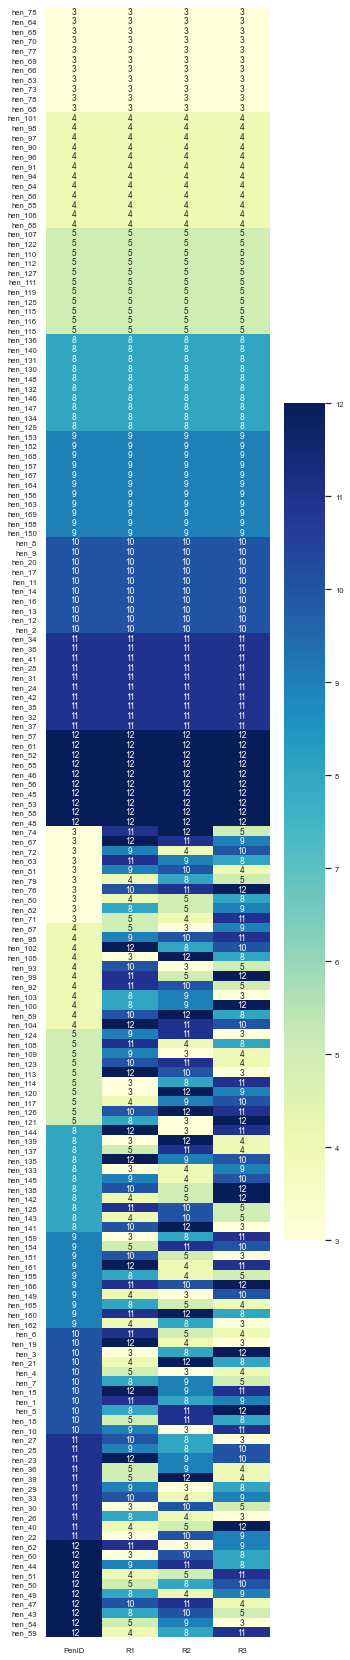

In [20]:
#visually over time per HEN
df = shuffle(df, random_state=0)
df_plt = df[['RelocationBird','HenID','PenID','R1','R2','R3']].copy()
for c in ['PenID','R1','R2','R3']:
    df_plt[c] = df_plt[c].map(lambda x: int(x.split('en')[-1]))
df_plt = df_plt.sort_values(['RelocationBird','PenID'])
display(df_plt.head(3))
plt.figure(figsize=(5,30))
sns.set(font_scale=0.7)
sns.heatmap(df_plt[['PenID','R1','R2','R3']], yticklabels=df_plt['HenID'].tolist(), xticklabels=['PenID','R1','R2','R3'], 
            cmap="YlGnBu", annot=True)
plt.savefig(os.path.join(path_extracted_data,'Relocations.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();